#Questions:
- Should data augmentation not be added with transforms with original data ?
- Can the LSTM be implemented as the first layer of our model ?
- What is the best manner to fine tune the hyperparameters ?
- Should we implement an early stop in our training part ? or should we only take the best accuracy/f1 score over all epochs to evaluate or model ?


# CNN model (from "Fast Solar Image Classification Using Deep Learning and its Importance for Automation in Solar Physics" - Convolutional neural network)

## 0. Load modules


In [1]:
# Main libraries used all the time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Operating system libraries
import os
import sys

# Machine learning libraries
import torch
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, random_split

import torch.nn as nn
import torch.optim as optim
import argparse
from tqdm import tqdm


from torchvision.transforms import v2 # library to define the transforms

!pip install torcheval  # needs to run on google colab, on local machine you can just "pip install torcheval" in the terminal
from torcheval.metrics.functional import multiclass_f1_score

# Visualization and debugging
from sklearn.metrics import confusion_matrix
import seaborn as sns
!pip install sunpy
from sunpy.visualization.colormaps import color_tables as ct


## 1. Import the data, create the dataset, define the Dataloaders

### 1.1 Declare data path

In [2]:
# For Google Colab, mount Google Drive, for local environments, get local path (github)

# Change with the appropriate path. Log in into Drive and create the folders with the data

if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    # Carlos
    #folder0_path = '/content/drive/My Drive/solar_jets/data0'
    #folder0_test_path = '/content/drive/My Drive/solar_jets/data0_test'
    #folder1_path = '/content/drive/My Drive/solar_jets/data1'
    #folder1_test_path = '/content/drive/My Drive/solar_jets/data1_test'

    # Julie
    #folder0_path = '/content/drive/My Drive/Colab Notebooks/CS433-project2/data0'
    #folder1_path = '/content/drive/My Drive/Colab Notebooks/CS433-project2/data1'

    #folder0_test_path = '/content/drive/My Drive/Colab Notebooks/CS433-project2/data0_val'
    #folder1_test_path = '/content/drive/My Drive/Colab Notebooks/CS433-project2/data1_val'


    #Adrien
    folder0_path = '/content/drive/My Drive/Machine Learning/Projet/data0'
    folder1_path = '/content/drive/My Drive/Machine Learning/Projet/data1'
    folder0_test_path = '/content/drive/My Drive/Machine Learning/Projet/data0_test'
    folder1_test_path = '/content/drive/My Drive/Machine Learning/Projet/data1_test'
    folder0_valid_path = '/content/drive/My Drive/Machine Learning/Projet/data0_val'
    folder1_valid_path = '/content/drive/My Drive/Machine Learning/Projet/data1_val'
else:
    # For local environments like VS Code
    folder0_path = './data0'
    folder1_path = './data1'
    folder0_test_path = './data0_test'
    folder1_test_path = './data1_test'
    folder0_valid_path = './data0_val'
    folder1_valid_path = './data1_val'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 1.2 Declare the class and the transforms

In [19]:
class NPZDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir

        # in self.files, only add f if it has 30 samples
        self.files = [f for f in os.listdir(data_dir) if self._check_file_shape(f)]
        self.transform = transform

    # Check if the file has 30 samples, if not, don't include it in self.files (see above)
    def _check_file_shape(self, file):
        file_path = os.path.join(self.data_dir, file)
        data = np.load(file_path)['arr_0']
        return data.shape == (166, 166, 30)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path = os.path.join(self.data_dir, self.files[idx])
        data = np.load(file_path)['arr_0']

        # Rearrange dimensions to (30, 166, 166) for PyTorch (insted of (166, 166, 30))
        data = np.moveaxis(data, -1, 0)

        # assign label 1 if data is from data1, 0 if from data0
        label = 1.0 if 'data1' in self.data_dir else 0.0
        return torch.from_numpy(data).float(), label

In [20]:
mean = 51.6644
std = 62.7087

train_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True), #equivalent to transforms.ToTensor()

    #v2.RandomResizedCrop(size=(55, 55)),                                          # weird pixelized img, we don't see the jet well sometimes
    #v2.RandomAffine(degrees=(-90,90), translate=(0.3, 0.3), scale=(0.8, 1.2)),    # good+useful if future sequences are not well cut out, moves the jet around the img
    #v2.RandomHorizontalFlip(p=0.4),                                               # just flips the image, no big difference
    #v2.RandomVerticalFlip(p=0.4),                                                 # same
    #v2.RandomRotation(degrees=(-90,90)),                                          # rotation, jet stays at the center of the image
    #v2.RandomZoomOut(side_range=(1,3), p=0.4),                                    # makes the jet smaller and not necessarely centered

    v2.Normalize((mean,), (std,)),
    # add other transforms if needed
])

test_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True), #equivalent to transforms.ToTensor()
    v2.Normalize((mean,), (std,)),
])

### 1.3 Get the data, declare the Dataloaders

In [21]:
train_data1 = NPZDataset(folder1_path, transform=train_transform)
train_data0 = NPZDataset(folder0_path, transform=train_transform)
train_data = torch.utils.data.ConcatDataset([train_data1, train_data0])

test_data1 = NPZDataset(folder1_test_path, transform=test_transform)
test_data0 = NPZDataset(folder0_test_path, transform=test_transform)
test_data = torch.utils.data.ConcatDataset([test_data1, test_data0])

valid_data1 = NPZDataset(folder1_valid_path, transform=test_transform) #We can keep the same transforms as the test one
valid_data0 = NPZDataset(folder0_valid_path, transform=test_transform)
valid_data = torch.utils.data.ConcatDataset([valid_data1, valid_data0])

Visualize transforms: shows 5 images (10-15 of a sequence) of a chosen sequence in the data. The transform shown is the train_transform defined 2 cells above

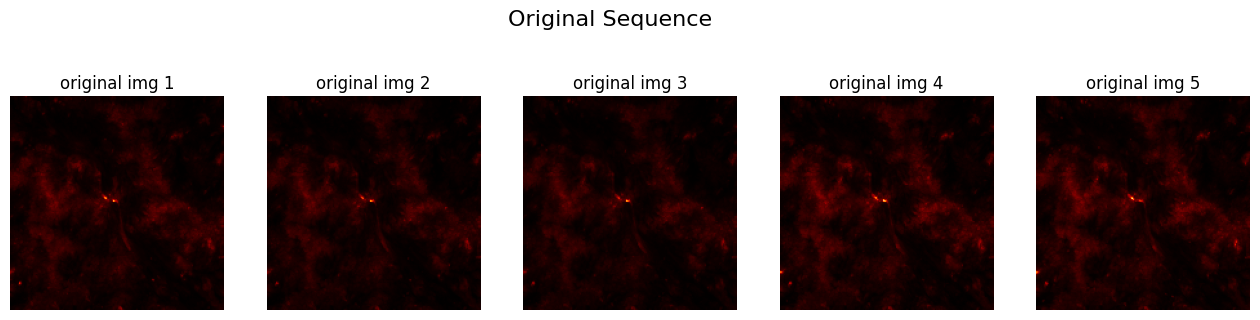

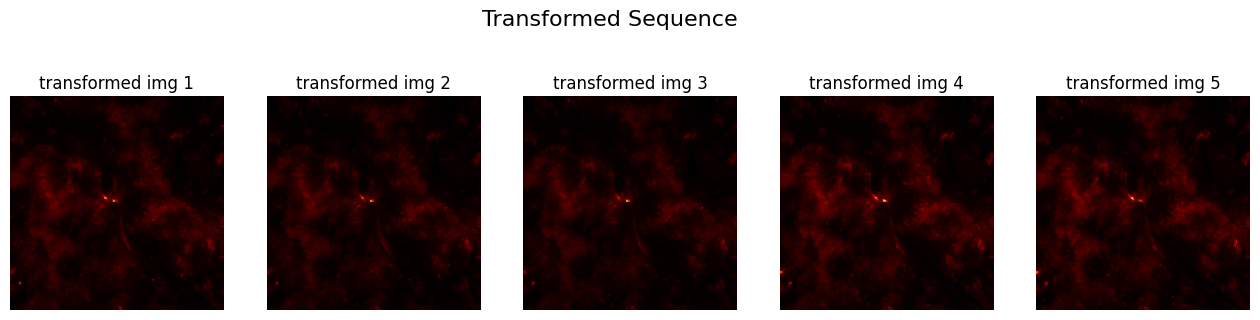

In [22]:
idx = 33 # index of image to visualize
sample_sequence, _ = train_data[idx]
original_sequence = np.moveaxis(sample_sequence.numpy(), 0, -1)  # Move axes back for visualization

# Display the original sequence

plt.figure(figsize=(16, 4))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(original_sequence[:, :, 10+i], cmap='sdoaia304')
    plt.title(f'original img {i + 1}')
    plt.axis('off')

plt.suptitle('Original Sequence', fontsize=16)

# Plot the transformed sequence

plt.figure(figsize=(16, 4))
i = 0

for image in sample_sequence[10:15]:
    plt.subplot(1, 5, i + 1)
    trans = train_transform(image)
    plt.imshow(trans.squeeze(), cmap='sdoaia304')
    plt.title(f'transformed img {i + 1}')
    plt.axis('off')
    i += 1

plt.suptitle('Transformed Sequence', fontsize=16)
plt.show()

## 2. Define the CNN

In [23]:
import torch
import torch.nn as nn
from torch.nn.init import kaiming_normal_

class RCNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.max_pool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.layer1 = nn.Sequential(
            nn.Conv2d(30,64,kernel_size=3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64,64,kernel_size=3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(64,128,kernel_size=3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(128,128,kernel_size=3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(128,256,kernel_size=3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.layer6 = nn.Sequential(
            nn.Conv2d(256,256,kernel_size=3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.layer7 = nn.Sequential(
            nn.Conv2d(256,512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.layer8 = nn.Sequential(
            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        # hidden_size is an hyperparameter to be adjusted
        # try augmenting num_layers
        self.lstm = nn.LSTM(input_size=12800, hidden_size=512, num_layers=1, batch_first=True)

        self.classifier = nn.Sequential(
            nn.Linear(512,4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096,4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096,2)
        )

        for m in self.modules():
            if not RCNN:
                kaiming_normal_(m.weight,nonlinearity="relu")#Kaiming to initialize the weights

    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.max_pool(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.max_pool(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.max_pool(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.max_pool(out)
        out = self.layer8(out)
        out = self.layer8(out)
        out = self.max_pool(out)
        out = out.view(out.size(0),-1)
        lstm_out, _ = self.lstm(out)
        out = self.classifier(lstm_out)

        return out

    def graph(self): #for visualization and debugging
        return nn.Sequential(self.layer1,self.layer2,self.maxPool,self.layer3,self.layer4,self.maxPool,self.layer5,self.layer6,self.maxPool,self.layer7,self.layer8, self.maxPool,self.layer8,self.layer8,self.maxPool,self.classifier)

## 3. Define the training and validation functions

In [24]:
def train_epoch(model,device,data_loader,optimizer,epoch,criterion,scheduler):
    metrics="yes"
    model.train()

    for i, (images, labels) in tqdm(enumerate(data_loader),desc="Epoch no."+str(epoch)): #here the images are the pytorch tensor and labels are long 1 or 0
        images, labels = images.to(device), labels.long().to(device) #Give data and label to device (model already done above)
        optimizer.zero_grad() #must zero the gradients in the optimiser since backward() accumulates gradients and this stops mixing of values between batches
        output = model(images) #feeds the data through the network
        loss = criterion(output,labels) #finds the distance in the loss space between predicted values and actual values
        loss.backward() #backpropagation of the loss
        optimizer.step()

        #Metrics
        if metrics=="yes":
          loss_history_train.append(loss.item())

          pred = output.argmax(dim=1, keepdim=True)
          correct = pred.eq(labels.view_as(pred)).sum().item()
          accuracy_float = correct / len(images)
          acc_history_train.append(accuracy_float)

    scheduler.step()
    lr_history_train.append(scheduler.get_last_lr()[0])

In [25]:
def validate(model,device,data_loader,epoch,criterion):
    model.eval()
    total, correct = 0, 0
    test_loss = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.long().to(device)
            output = model(images)
            _, predicted = torch.max(output.data,1) #gives the max output index (that is our label)

            #Metrics
            total += labels.size(0)
            correct += (predicted == labels).sum()

            test_loss += criterion(output, labels).item() * len(images)
    print("Test Accuracy of the model on the test images: %f %% on epoch %d" % (100 * correct / total, epoch))

    #Metrics
    acc_history_test.append((correct / total).cpu().detach().numpy())

    test_loss /= len(data_loader.dataset)
    loss_history_test.append(test_loss)

In [26]:
#Model
model = RCNN() #creates an instance of the RCNN

#Hyperparameters
num_epochs=20   #by performing cross validation on bach and lr parameters : batch_size=2 and lr=1e-4 (Note : Learning rate can go even lower) , if we want to increase batch size we need to increase learning rate probably
batch_size=2

#Loading in consequence

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=True)

#Other Hyperparameters

criterion = nn.CrossEntropyLoss()


"""
optimizer_kwargs = dict(
    lr=1e-4,
    weight_decay=1e-3,
)

optimizer = torch.optim.AdamW(model.parameters(), **optimizer_kwargs)
"""

optimizer = optim.SGD(model.parameters(),lr=1e-4,momentum=0.9,nesterov=True)#Seems better optimizer than Adam for less epochs, we can increase lr as we are using scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR( #designed to adapt the learning rate during epochs
    optimizer,
    T_max=(len(train_loader.dataset) * num_epochs) // train_loader.batch_size,
    )


#Parameters and Metrics
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

loss_history_train=[]
lr_history_train=[]
acc_history_train=[]

acc_history_test=[]
loss_history_test=[]


model.to(device)


for i in tqdm(range(1,num_epochs+1)):
  train_epoch(model,device,train_loader,optimizer,i,criterion, scheduler)
  validate(model,device,valid_loader,i, criterion)
  print(acc_history_test,loss_history_test)
  #Maybe implement an early stop of the model when a criterion is met --> if loss or accuracy or f1 score of validation set is deacreasing

cuda


  0%|          | 0/20 [00:00<?, ?it/s]
Epoch no.1: 0it [00:00, ?it/s]
Epoch no.1: 1it [00:00,  9.74it/s]
Epoch no.1: 2it [00:00,  9.21it/s]
Epoch no.1: 3it [00:00,  8.91it/s]
Epoch no.1: 4it [00:00,  9.19it/s]
Epoch no.1: 5it [00:00,  9.35it/s]
Epoch no.1: 7it [00:00,  9.81it/s]
Epoch no.1: 9it [00:00,  9.96it/s]
Epoch no.1: 10it [00:01,  9.94it/s]
Epoch no.1: 12it [00:01,  9.95it/s]
Epoch no.1: 13it [00:01,  9.72it/s]
Epoch no.1: 14it [00:01,  9.69it/s]
Epoch no.1: 16it [00:01, 10.00it/s]
Epoch no.1: 18it [00:01, 10.18it/s]
Epoch no.1: 20it [00:02, 10.31it/s]
Epoch no.1: 22it [00:02, 10.29it/s]
Epoch no.1: 24it [00:02, 10.25it/s]
Epoch no.1: 26it [00:02, 10.26it/s]
Epoch no.1: 28it [00:02, 10.45it/s]
Epoch no.1: 30it [00:02, 10.64it/s]
Epoch no.1: 32it [00:03, 10.79it/s]
Epoch no.1: 34it [00:03, 10.19it/s]
Epoch no.1: 36it [00:03, 10.06it/s]
Epoch no.1: 38it [00:03,  9.87it/s]
Epoch no.1: 39it [00:03,  9.80it/s]
Epoch no.1: 40it [00:04,  9.65it/s]
Epoch no.1: 41it [00:04,  9.43it/s]
E

Test Accuracy of the model on the test images: 62.301590 % on epoch 1
[array(0.6230159, dtype=float32)] [0.6545415142225841]



Epoch no.2: 0it [00:00, ?it/s]
Epoch no.2: 1it [00:00,  5.16it/s]
Epoch no.2: 2it [00:00,  3.69it/s]
Epoch no.2: 3it [00:00,  4.22it/s]
Epoch no.2: 4it [00:00,  4.09it/s]
Epoch no.2: 5it [00:01,  4.62it/s]
Epoch no.2: 6it [00:01,  4.08it/s]
Epoch no.2: 7it [00:01,  4.04it/s]
Epoch no.2: 8it [00:01,  4.24it/s]
Epoch no.2: 9it [00:02,  4.07it/s]
Epoch no.2: 10it [00:02,  4.47it/s]
Epoch no.2: 11it [00:02,  4.42it/s]
Epoch no.2: 12it [00:02,  5.02it/s]
Epoch no.2: 13it [00:02,  5.18it/s]
Epoch no.2: 14it [00:03,  4.70it/s]
Epoch no.2: 15it [00:03,  4.96it/s]
Epoch no.2: 16it [00:03,  5.01it/s]
Epoch no.2: 17it [00:03,  5.02it/s]
Epoch no.2: 18it [00:03,  5.14it/s]
Epoch no.2: 19it [00:04,  5.10it/s]
Epoch no.2: 20it [00:04,  5.40it/s]
Epoch no.2: 21it [00:04,  5.53it/s]
Epoch no.2: 22it [00:04,  5.59it/s]
Epoch no.2: 23it [00:04,  4.76it/s]
Epoch no.2: 24it [00:05,  4.60it/s]
Epoch no.2: 25it [00:05,  5.39it/s]
Epoch no.2: 26it [00:05,  6.10it/s]
Epoch no.2: 27it [00:05,  6.71it/s]
Epoch

Test Accuracy of the model on the test images: 63.095242 % on epoch 2
[array(0.6230159, dtype=float32), array(0.6309524, dtype=float32)] [0.6545415142225841, 0.6324001212441732]



Epoch no.3: 0it [00:00, ?it/s]
Epoch no.3: 1it [00:00,  6.76it/s]
Epoch no.3: 2it [00:00,  5.76it/s]
Epoch no.3: 3it [00:00,  6.41it/s]
Epoch no.3: 4it [00:00,  6.79it/s]
Epoch no.3: 5it [00:00,  7.32it/s]
Epoch no.3: 6it [00:00,  7.76it/s]
Epoch no.3: 7it [00:00,  7.90it/s]
Epoch no.3: 8it [00:01,  8.40it/s]
Epoch no.3: 9it [00:01,  8.70it/s]
Epoch no.3: 10it [00:01,  8.55it/s]
Epoch no.3: 11it [00:01,  8.69it/s]
Epoch no.3: 12it [00:01,  8.87it/s]
Epoch no.3: 13it [00:01,  8.93it/s]
Epoch no.3: 14it [00:01,  9.14it/s]
Epoch no.3: 15it [00:01,  8.77it/s]
Epoch no.3: 16it [00:01,  8.56it/s]
Epoch no.3: 17it [00:02,  8.44it/s]
Epoch no.3: 18it [00:02,  8.79it/s]
Epoch no.3: 19it [00:02,  8.92it/s]
Epoch no.3: 20it [00:02,  9.18it/s]
Epoch no.3: 21it [00:02,  9.40it/s]
Epoch no.3: 22it [00:02,  9.14it/s]
Epoch no.3: 23it [00:02,  8.78it/s]
Epoch no.3: 24it [00:02,  8.80it/s]
Epoch no.3: 25it [00:02,  8.61it/s]
Epoch no.3: 26it [00:03,  8.91it/s]
Epoch no.3: 27it [00:03,  9.03it/s]
Epoch

Test Accuracy of the model on the test images: 66.269844 % on epoch 3
[array(0.6230159, dtype=float32), array(0.6309524, dtype=float32), array(0.66269845, dtype=float32)] [0.6545415142225841, 0.6324001212441732, 0.5831671750971249]



Epoch no.4: 0it [00:00, ?it/s]
Epoch no.4: 1it [00:00,  6.60it/s]
Epoch no.4: 2it [00:00,  7.93it/s]
Epoch no.4: 3it [00:00,  8.09it/s]
Epoch no.4: 4it [00:00,  8.38it/s]
Epoch no.4: 5it [00:00,  8.82it/s]
Epoch no.4: 6it [00:00,  8.86it/s]
Epoch no.4: 7it [00:00,  7.57it/s]
Epoch no.4: 8it [00:01,  6.63it/s]
Epoch no.4: 9it [00:01,  7.30it/s]
Epoch no.4: 10it [00:01,  7.79it/s]
Epoch no.4: 11it [00:01,  8.12it/s]
Epoch no.4: 13it [00:01,  9.03it/s]
Epoch no.4: 14it [00:01,  8.27it/s]
Epoch no.4: 15it [00:01,  8.25it/s]
Epoch no.4: 16it [00:01,  8.08it/s]
Epoch no.4: 17it [00:02,  7.71it/s]
Epoch no.4: 18it [00:02,  7.87it/s]
Epoch no.4: 19it [00:02,  7.98it/s]
Epoch no.4: 20it [00:02,  8.42it/s]
Epoch no.4: 21it [00:02,  8.81it/s]
Epoch no.4: 22it [00:02,  8.06it/s]
Epoch no.4: 23it [00:02,  8.10it/s]
Epoch no.4: 24it [00:02,  8.42it/s]
Epoch no.4: 25it [00:03,  7.77it/s]
Epoch no.4: 26it [00:03,  7.75it/s]
Epoch no.4: 27it [00:03,  8.20it/s]
Epoch no.4: 28it [00:03,  8.43it/s]
Epoch

Test Accuracy of the model on the test images: 76.587303 % on epoch 4
[array(0.6230159, dtype=float32), array(0.6309524, dtype=float32), array(0.66269845, dtype=float32), array(0.7658731, dtype=float32)] [0.6545415142225841, 0.6324001212441732, 0.5831671750971249, 0.5104362203015221]



Epoch no.5: 0it [00:00, ?it/s]
Epoch no.5: 1it [00:00,  9.40it/s]
Epoch no.5: 2it [00:00,  9.55it/s]
Epoch no.5: 3it [00:00,  9.74it/s]
Epoch no.5: 4it [00:00,  9.47it/s]
Epoch no.5: 6it [00:00, 10.04it/s]
Epoch no.5: 7it [00:00,  9.72it/s]
Epoch no.5: 8it [00:00,  9.20it/s]
Epoch no.5: 9it [00:00,  9.22it/s]
Epoch no.5: 10it [00:01,  9.08it/s]
Epoch no.5: 11it [00:01,  9.23it/s]
Epoch no.5: 12it [00:01,  9.10it/s]
Epoch no.5: 13it [00:01,  9.04it/s]
Epoch no.5: 14it [00:01,  9.02it/s]
Epoch no.5: 15it [00:01,  9.24it/s]
Epoch no.5: 16it [00:01,  9.19it/s]
Epoch no.5: 17it [00:01,  9.09it/s]
Epoch no.5: 18it [00:01,  8.98it/s]
Epoch no.5: 19it [00:02,  9.13it/s]
Epoch no.5: 20it [00:02,  9.20it/s]
Epoch no.5: 21it [00:02,  9.10it/s]
Epoch no.5: 22it [00:02,  9.16it/s]
Epoch no.5: 23it [00:02,  9.06it/s]
Epoch no.5: 24it [00:02,  9.06it/s]
Epoch no.5: 25it [00:02,  9.14it/s]
Epoch no.5: 26it [00:02,  9.06it/s]
Epoch no.5: 27it [00:02,  8.95it/s]
Epoch no.5: 28it [00:03,  8.92it/s]
Epoc

Test Accuracy of the model on the test images: 76.587303 % on epoch 5
[array(0.6230159, dtype=float32), array(0.6309524, dtype=float32), array(0.66269845, dtype=float32), array(0.7658731, dtype=float32), array(0.7658731, dtype=float32)] [0.6545415142225841, 0.6324001212441732, 0.5831671750971249, 0.5104362203015221, 0.49991741758726893]



Epoch no.6: 0it [00:00, ?it/s]
Epoch no.6: 1it [00:00,  8.01it/s]
Epoch no.6: 2it [00:00,  8.26it/s]
Epoch no.6: 3it [00:00,  8.19it/s]
Epoch no.6: 4it [00:00,  8.08it/s]
Epoch no.6: 5it [00:00,  8.22it/s]
Epoch no.6: 6it [00:00,  8.24it/s]
Epoch no.6: 7it [00:00,  8.35it/s]
Epoch no.6: 8it [00:00,  8.36it/s]
Epoch no.6: 9it [00:01,  8.42it/s]
Epoch no.6: 10it [00:01,  8.28it/s]
Epoch no.6: 11it [00:01,  8.21it/s]
Epoch no.6: 12it [00:01,  8.43it/s]
Epoch no.6: 13it [00:01,  8.46it/s]
Epoch no.6: 14it [00:01,  8.77it/s]
Epoch no.6: 15it [00:01,  8.74it/s]
Epoch no.6: 16it [00:01,  8.67it/s]
Epoch no.6: 17it [00:02,  8.99it/s]
Epoch no.6: 18it [00:02,  9.11it/s]
Epoch no.6: 19it [00:02,  9.33it/s]
Epoch no.6: 21it [00:02,  9.85it/s]
Epoch no.6: 23it [00:02, 10.10it/s]
Epoch no.6: 25it [00:02, 10.23it/s]
Epoch no.6: 27it [00:02, 10.30it/s]
Epoch no.6: 29it [00:03, 10.37it/s]
Epoch no.6: 31it [00:03, 10.47it/s]
Epoch no.6: 33it [00:03, 10.51it/s]
Epoch no.6: 35it [00:03, 10.53it/s]
Epoch

Test Accuracy of the model on the test images: 80.952385 % on epoch 6
[array(0.6230159, dtype=float32), array(0.6309524, dtype=float32), array(0.66269845, dtype=float32), array(0.7658731, dtype=float32), array(0.7658731, dtype=float32), array(0.8095239, dtype=float32)] [0.6545415142225841, 0.6324001212441732, 0.5831671750971249, 0.5104362203015221, 0.49991741758726893, 0.42830985808183275]



Epoch no.7: 0it [00:00, ?it/s]
Epoch no.7: 1it [00:00,  9.85it/s]
Epoch no.7: 2it [00:00,  9.50it/s]
Epoch no.7: 3it [00:00,  9.25it/s]
Epoch no.7: 4it [00:00,  9.39it/s]
Epoch no.7: 5it [00:00,  9.32it/s]
Epoch no.7: 6it [00:00,  9.37it/s]
Epoch no.7: 7it [00:00,  9.24it/s]
Epoch no.7: 8it [00:00,  9.26it/s]
Epoch no.7: 9it [00:00,  9.34it/s]
Epoch no.7: 10it [00:01,  9.44it/s]
Epoch no.7: 11it [00:01,  9.54it/s]
Epoch no.7: 12it [00:01,  9.58it/s]
Epoch no.7: 13it [00:01,  9.51it/s]
Epoch no.7: 14it [00:01,  9.54it/s]
Epoch no.7: 15it [00:01,  9.50it/s]
Epoch no.7: 16it [00:01,  9.55it/s]
Epoch no.7: 17it [00:01,  9.30it/s]
Epoch no.7: 18it [00:01,  9.29it/s]
Epoch no.7: 19it [00:02,  9.30it/s]
Epoch no.7: 20it [00:02,  9.04it/s]
Epoch no.7: 21it [00:02,  9.11it/s]
Epoch no.7: 22it [00:02,  9.33it/s]
Epoch no.7: 23it [00:02,  9.37it/s]
Epoch no.7: 24it [00:02,  9.36it/s]
Epoch no.7: 25it [00:02,  9.33it/s]
Epoch no.7: 26it [00:02,  9.52it/s]
Epoch no.7: 28it [00:02, 10.05it/s]
Epoch

Test Accuracy of the model on the test images: 80.555557 % on epoch 7
[array(0.6230159, dtype=float32), array(0.6309524, dtype=float32), array(0.66269845, dtype=float32), array(0.7658731, dtype=float32), array(0.7658731, dtype=float32), array(0.8095239, dtype=float32), array(0.8055556, dtype=float32)] [0.6545415142225841, 0.6324001212441732, 0.5831671750971249, 0.5104362203015221, 0.49991741758726893, 0.42830985808183275, 0.4266170011094165]



Epoch no.8: 0it [00:00, ?it/s]
Epoch no.8: 1it [00:00,  9.71it/s]
Epoch no.8: 2it [00:00,  9.44it/s]
Epoch no.8: 3it [00:00,  9.62it/s]
Epoch no.8: 4it [00:00,  9.34it/s]
Epoch no.8: 5it [00:00,  9.42it/s]
Epoch no.8: 6it [00:00,  9.59it/s]
Epoch no.8: 7it [00:00,  9.41it/s]
Epoch no.8: 8it [00:00,  9.53it/s]
Epoch no.8: 9it [00:00,  9.58it/s]
Epoch no.8: 10it [00:01,  9.37it/s]
Epoch no.8: 11it [00:01,  9.45it/s]
Epoch no.8: 12it [00:01,  9.56it/s]
Epoch no.8: 13it [00:01,  9.62it/s]
Epoch no.8: 14it [00:01,  9.47it/s]
Epoch no.8: 15it [00:01,  9.45it/s]
Epoch no.8: 16it [00:01,  9.54it/s]
Epoch no.8: 18it [00:01,  9.90it/s]
Epoch no.8: 20it [00:02, 10.11it/s]
Epoch no.8: 21it [00:02,  9.97it/s]
Epoch no.8: 23it [00:02, 10.25it/s]
Epoch no.8: 25it [00:02, 10.08it/s]
Epoch no.8: 27it [00:02,  9.77it/s]
Epoch no.8: 28it [00:02,  9.63it/s]
Epoch no.8: 29it [00:03,  9.53it/s]
Epoch no.8: 30it [00:03,  9.26it/s]
Epoch no.8: 31it [00:03,  9.20it/s]
Epoch no.8: 32it [00:03,  8.88it/s]
Epoch

Test Accuracy of the model on the test images: 82.142860 % on epoch 8
[array(0.6230159, dtype=float32), array(0.6309524, dtype=float32), array(0.66269845, dtype=float32), array(0.7658731, dtype=float32), array(0.7658731, dtype=float32), array(0.8095239, dtype=float32), array(0.8055556, dtype=float32), array(0.8214286, dtype=float32)] [0.6545415142225841, 0.6324001212441732, 0.5831671750971249, 0.5104362203015221, 0.49991741758726893, 0.42830985808183275, 0.4266170011094165, 0.41328236031981685]



Epoch no.9: 0it [00:00, ?it/s]
Epoch no.9: 1it [00:00,  8.01it/s]
Epoch no.9: 2it [00:00,  7.75it/s]
Epoch no.9: 3it [00:00,  8.15it/s]
Epoch no.9: 4it [00:00,  8.24it/s]
Epoch no.9: 5it [00:00,  8.36it/s]
Epoch no.9: 6it [00:00,  8.16it/s]
Epoch no.9: 7it [00:00,  7.93it/s]
Epoch no.9: 8it [00:00,  8.02it/s]
Epoch no.9: 9it [00:01,  8.01it/s]
Epoch no.9: 10it [00:01,  8.18it/s]
Epoch no.9: 11it [00:01,  8.28it/s]
Epoch no.9: 12it [00:01,  8.25it/s]
Epoch no.9: 13it [00:01,  8.28it/s]
Epoch no.9: 14it [00:01,  8.25it/s]
Epoch no.9: 15it [00:01,  8.08it/s]
Epoch no.9: 16it [00:01,  8.17it/s]
Epoch no.9: 17it [00:02,  8.20it/s]
Epoch no.9: 18it [00:02,  8.54it/s]
Epoch no.9: 19it [00:02,  8.77it/s]
Epoch no.9: 21it [00:02,  9.45it/s]
Epoch no.9: 22it [00:02,  9.48it/s]
Epoch no.9: 23it [00:02,  9.55it/s]
Epoch no.9: 24it [00:02,  9.44it/s]
Epoch no.9: 25it [00:02,  9.52it/s]
Epoch no.9: 26it [00:03,  9.54it/s]
Epoch no.9: 27it [00:03,  9.67it/s]
Epoch no.9: 28it [00:03,  9.57it/s]
Epoch

Test Accuracy of the model on the test images: 75.000008 % on epoch 9
[array(0.6230159, dtype=float32), array(0.6309524, dtype=float32), array(0.66269845, dtype=float32), array(0.7658731, dtype=float32), array(0.7658731, dtype=float32), array(0.8095239, dtype=float32), array(0.8055556, dtype=float32), array(0.8214286, dtype=float32), array(0.75000006, dtype=float32)] [0.6545415142225841, 0.6324001212441732, 0.5831671750971249, 0.5104362203015221, 0.49991741758726893, 0.42830985808183275, 0.4266170011094165, 0.41328236031981685, 0.5217862069045031]



Epoch no.10: 0it [00:00, ?it/s]
Epoch no.10: 1it [00:00,  9.32it/s]
Epoch no.10: 2it [00:00,  9.48it/s]
Epoch no.10: 3it [00:00,  9.52it/s]
Epoch no.10: 4it [00:00,  9.15it/s]
Epoch no.10: 5it [00:00,  9.25it/s]
Epoch no.10: 7it [00:00,  9.81it/s]
Epoch no.10: 8it [00:00,  9.76it/s]
Epoch no.10: 9it [00:00,  9.74it/s]
Epoch no.10: 10it [00:01,  9.63it/s]
Epoch no.10: 11it [00:01,  9.61it/s]
Epoch no.10: 12it [00:01,  9.64it/s]
Epoch no.10: 13it [00:01,  9.71it/s]
Epoch no.10: 14it [00:01,  9.64it/s]
Epoch no.10: 15it [00:01,  9.57it/s]
Epoch no.10: 16it [00:01,  9.45it/s]
Epoch no.10: 18it [00:01,  9.85it/s]
Epoch no.10: 19it [00:01,  9.69it/s]
Epoch no.10: 20it [00:02,  9.68it/s]
Epoch no.10: 21it [00:02,  9.56it/s]
Epoch no.10: 22it [00:02,  9.60it/s]
Epoch no.10: 23it [00:02,  9.58it/s]
Epoch no.10: 25it [00:02,  9.92it/s]
Epoch no.10: 26it [00:02,  9.87it/s]
Epoch no.10: 27it [00:02,  9.83it/s]
Epoch no.10: 28it [00:02,  9.79it/s]
Epoch no.10: 29it [00:03,  9.61it/s]
Epoch no.10: 

Test Accuracy of the model on the test images: 76.984131 % on epoch 10
[array(0.6230159, dtype=float32), array(0.6309524, dtype=float32), array(0.66269845, dtype=float32), array(0.7658731, dtype=float32), array(0.7658731, dtype=float32), array(0.8095239, dtype=float32), array(0.8055556, dtype=float32), array(0.8214286, dtype=float32), array(0.75000006, dtype=float32), array(0.7698413, dtype=float32)] [0.6545415142225841, 0.6324001212441732, 0.5831671750971249, 0.5104362203015221, 0.49991741758726893, 0.42830985808183275, 0.4266170011094165, 0.41328236031981685, 0.5217862069045031, 0.5233746551952901]



Epoch no.11: 0it [00:00, ?it/s]
Epoch no.11: 1it [00:00,  7.90it/s]
Epoch no.11: 2it [00:00,  7.74it/s]
Epoch no.11: 3it [00:00,  7.54it/s]
Epoch no.11: 4it [00:00,  7.33it/s]
Epoch no.11: 5it [00:00,  7.44it/s]
Epoch no.11: 6it [00:00,  7.63it/s]
Epoch no.11: 7it [00:00,  7.79it/s]
Epoch no.11: 8it [00:01,  7.64it/s]
Epoch no.11: 9it [00:01,  7.61it/s]
Epoch no.11: 10it [00:01,  7.43it/s]
Epoch no.11: 11it [00:01,  7.73it/s]
Epoch no.11: 12it [00:01,  7.91it/s]
Epoch no.11: 13it [00:01,  8.22it/s]
Epoch no.11: 14it [00:01,  8.32it/s]
Epoch no.11: 15it [00:01,  8.09it/s]
Epoch no.11: 16it [00:02,  8.01it/s]
Epoch no.11: 17it [00:02,  8.08it/s]
Epoch no.11: 18it [00:02,  8.17it/s]
Epoch no.11: 19it [00:02,  8.14it/s]
Epoch no.11: 20it [00:02,  8.08it/s]
Epoch no.11: 21it [00:02,  8.11it/s]
Epoch no.11: 22it [00:02,  8.11it/s]
Epoch no.11: 23it [00:02,  8.39it/s]
Epoch no.11: 24it [00:03,  8.53it/s]
Epoch no.11: 25it [00:03,  8.43it/s]
Epoch no.11: 26it [00:03,  8.43it/s]
Epoch no.11: 2

Test Accuracy of the model on the test images: 75.000008 % on epoch 11
[array(0.6230159, dtype=float32), array(0.6309524, dtype=float32), array(0.66269845, dtype=float32), array(0.7658731, dtype=float32), array(0.7658731, dtype=float32), array(0.8095239, dtype=float32), array(0.8055556, dtype=float32), array(0.8214286, dtype=float32), array(0.75000006, dtype=float32), array(0.7698413, dtype=float32), array(0.75000006, dtype=float32)] [0.6545415142225841, 0.6324001212441732, 0.5831671750971249, 0.5104362203015221, 0.49991741758726893, 0.42830985808183275, 0.4266170011094165, 0.41328236031981685, 0.5217862069045031, 0.5233746551952901, 0.586515750939263]



Epoch no.12: 0it [00:00, ?it/s]
Epoch no.12: 1it [00:00,  9.21it/s]
Epoch no.12: 2it [00:00,  9.43it/s]
Epoch no.12: 3it [00:00,  9.27it/s]
Epoch no.12: 4it [00:00,  9.27it/s]
Epoch no.12: 5it [00:00,  9.30it/s]
Epoch no.12: 6it [00:00,  9.33it/s]
Epoch no.12: 7it [00:00,  9.34it/s]
Epoch no.12: 8it [00:00,  9.25it/s]
Epoch no.12: 9it [00:00,  9.16it/s]
Epoch no.12: 10it [00:01,  9.34it/s]
Epoch no.12: 11it [00:01,  9.53it/s]
Epoch no.12: 12it [00:01,  9.29it/s]
Epoch no.12: 13it [00:01,  9.40it/s]
Epoch no.12: 14it [00:01,  9.45it/s]
Epoch no.12: 15it [00:01,  9.49it/s]
Epoch no.12: 16it [00:01,  9.51it/s]
Epoch no.12: 17it [00:01,  9.62it/s]
Epoch no.12: 18it [00:01,  9.53it/s]
Epoch no.12: 19it [00:02,  9.51it/s]
Epoch no.12: 20it [00:02,  9.47it/s]
Epoch no.12: 21it [00:02,  9.54it/s]
Epoch no.12: 22it [00:02,  9.42it/s]
Epoch no.12: 23it [00:02,  9.54it/s]
Epoch no.12: 24it [00:02,  9.47it/s]
Epoch no.12: 25it [00:02,  9.37it/s]
Epoch no.12: 26it [00:02,  9.54it/s]
Epoch no.12: 2

Test Accuracy of the model on the test images: 76.587303 % on epoch 12
[array(0.6230159, dtype=float32), array(0.6309524, dtype=float32), array(0.66269845, dtype=float32), array(0.7658731, dtype=float32), array(0.7658731, dtype=float32), array(0.8095239, dtype=float32), array(0.8055556, dtype=float32), array(0.8214286, dtype=float32), array(0.75000006, dtype=float32), array(0.7698413, dtype=float32), array(0.75000006, dtype=float32), array(0.7658731, dtype=float32)] [0.6545415142225841, 0.6324001212441732, 0.5831671750971249, 0.5104362203015221, 0.49991741758726893, 0.42830985808183275, 0.4266170011094165, 0.41328236031981685, 0.5217862069045031, 0.5233746551952901, 0.586515750939263, 0.5561104677987122]



Epoch no.13: 0it [00:00, ?it/s]
Epoch no.13: 1it [00:00,  9.14it/s]
Epoch no.13: 2it [00:00,  8.71it/s]
Epoch no.13: 3it [00:00,  8.89it/s]
Epoch no.13: 4it [00:00,  8.98it/s]
Epoch no.13: 5it [00:00,  9.23it/s]
Epoch no.13: 6it [00:00,  9.26it/s]
Epoch no.13: 7it [00:00,  9.17it/s]
Epoch no.13: 8it [00:00,  8.78it/s]
Epoch no.13: 9it [00:01,  8.88it/s]
Epoch no.13: 10it [00:01,  8.90it/s]
Epoch no.13: 11it [00:01,  8.84it/s]
Epoch no.13: 12it [00:01,  8.80it/s]
Epoch no.13: 13it [00:01,  8.54it/s]
Epoch no.13: 14it [00:01,  8.56it/s]
Epoch no.13: 15it [00:01,  8.54it/s]
Epoch no.13: 16it [00:01,  8.41it/s]
Epoch no.13: 17it [00:01,  8.38it/s]
Epoch no.13: 18it [00:02,  8.42it/s]
Epoch no.13: 19it [00:02,  8.34it/s]
Epoch no.13: 20it [00:02,  8.27it/s]
Epoch no.13: 21it [00:02,  8.13it/s]
Epoch no.13: 22it [00:02,  8.15it/s]
Epoch no.13: 23it [00:02,  8.26it/s]
Epoch no.13: 24it [00:02,  8.13it/s]
Epoch no.13: 25it [00:02,  8.03it/s]
Epoch no.13: 26it [00:03,  8.11it/s]
Epoch no.13: 2

Test Accuracy of the model on the test images: 83.333336 % on epoch 13
[array(0.6230159, dtype=float32), array(0.6309524, dtype=float32), array(0.66269845, dtype=float32), array(0.7658731, dtype=float32), array(0.7658731, dtype=float32), array(0.8095239, dtype=float32), array(0.8055556, dtype=float32), array(0.8214286, dtype=float32), array(0.75000006, dtype=float32), array(0.7698413, dtype=float32), array(0.75000006, dtype=float32), array(0.7658731, dtype=float32), array(0.8333334, dtype=float32)] [0.6545415142225841, 0.6324001212441732, 0.5831671750971249, 0.5104362203015221, 0.49991741758726893, 0.42830985808183275, 0.4266170011094165, 0.41328236031981685, 0.5217862069045031, 0.5233746551952901, 0.586515750939263, 0.5561104677987122, 0.38636243620163035]



Epoch no.14: 0it [00:00, ?it/s]
Epoch no.14: 1it [00:00,  8.80it/s]
Epoch no.14: 2it [00:00,  8.89it/s]
Epoch no.14: 3it [00:00,  8.83it/s]
Epoch no.14: 4it [00:00,  8.50it/s]
Epoch no.14: 5it [00:00,  8.50it/s]
Epoch no.14: 6it [00:00,  8.49it/s]
Epoch no.14: 7it [00:00,  8.72it/s]
Epoch no.14: 8it [00:00,  8.71it/s]
Epoch no.14: 9it [00:01,  8.86it/s]
Epoch no.14: 10it [00:01,  9.01it/s]
Epoch no.14: 11it [00:01,  9.09it/s]
Epoch no.14: 12it [00:01,  9.27it/s]
Epoch no.14: 13it [00:01,  9.29it/s]
Epoch no.14: 14it [00:01,  9.31it/s]
Epoch no.14: 15it [00:01,  9.49it/s]
Epoch no.14: 16it [00:01,  9.48it/s]
Epoch no.14: 17it [00:01,  9.50it/s]
Epoch no.14: 18it [00:01,  9.55it/s]
Epoch no.14: 19it [00:02,  9.44it/s]
Epoch no.14: 20it [00:02,  9.30it/s]
Epoch no.14: 21it [00:02,  9.26it/s]
Epoch no.14: 22it [00:02,  9.19it/s]
Epoch no.14: 23it [00:02,  9.25it/s]
Epoch no.14: 24it [00:02,  9.24it/s]
Epoch no.14: 25it [00:02,  9.26it/s]
Epoch no.14: 26it [00:02,  9.44it/s]
Epoch no.14: 2

Test Accuracy of the model on the test images: 79.365082 % on epoch 14
[array(0.6230159, dtype=float32), array(0.6309524, dtype=float32), array(0.66269845, dtype=float32), array(0.7658731, dtype=float32), array(0.7658731, dtype=float32), array(0.8095239, dtype=float32), array(0.8055556, dtype=float32), array(0.8214286, dtype=float32), array(0.75000006, dtype=float32), array(0.7698413, dtype=float32), array(0.75000006, dtype=float32), array(0.7658731, dtype=float32), array(0.8333334, dtype=float32), array(0.79365087, dtype=float32)] [0.6545415142225841, 0.6324001212441732, 0.5831671750971249, 0.5104362203015221, 0.49991741758726893, 0.42830985808183275, 0.4266170011094165, 0.41328236031981685, 0.5217862069045031, 0.5233746551952901, 0.586515750939263, 0.5561104677987122, 0.38636243620163035, 0.4855410560969234]



Epoch no.15: 0it [00:00, ?it/s]
Epoch no.15: 1it [00:00,  9.16it/s]
Epoch no.15: 2it [00:00,  9.01it/s]
Epoch no.15: 3it [00:00,  8.86it/s]
Epoch no.15: 4it [00:00,  9.00it/s]
Epoch no.15: 5it [00:00,  9.14it/s]
Epoch no.15: 6it [00:00,  9.15it/s]
Epoch no.15: 7it [00:00,  9.33it/s]
Epoch no.15: 8it [00:00,  9.26it/s]
Epoch no.15: 9it [00:00,  9.30it/s]
Epoch no.15: 10it [00:01,  9.42it/s]
Epoch no.15: 11it [00:01,  9.53it/s]
Epoch no.15: 13it [00:01,  9.98it/s]
Epoch no.15: 14it [00:01,  9.98it/s]
Epoch no.15: 15it [00:01,  9.84it/s]
Epoch no.15: 16it [00:01,  9.87it/s]
Epoch no.15: 17it [00:01,  9.90it/s]
Epoch no.15: 18it [00:01,  9.84it/s]
Epoch no.15: 19it [00:01,  9.82it/s]
Epoch no.15: 20it [00:02,  9.44it/s]
Epoch no.15: 21it [00:02,  9.28it/s]
Epoch no.15: 22it [00:02,  9.27it/s]
Epoch no.15: 23it [00:02,  9.37it/s]
Epoch no.15: 24it [00:02,  9.40it/s]
Epoch no.15: 25it [00:02,  9.27it/s]
Epoch no.15: 26it [00:02,  9.03it/s]
Epoch no.15: 27it [00:02,  9.15it/s]
Epoch no.15: 2

Test Accuracy of the model on the test images: 78.174606 % on epoch 15
[array(0.6230159, dtype=float32), array(0.6309524, dtype=float32), array(0.66269845, dtype=float32), array(0.7658731, dtype=float32), array(0.7658731, dtype=float32), array(0.8095239, dtype=float32), array(0.8055556, dtype=float32), array(0.8214286, dtype=float32), array(0.75000006, dtype=float32), array(0.7698413, dtype=float32), array(0.75000006, dtype=float32), array(0.7658731, dtype=float32), array(0.8333334, dtype=float32), array(0.79365087, dtype=float32), array(0.7817461, dtype=float32)] [0.6545415142225841, 0.6324001212441732, 0.5831671750971249, 0.5104362203015221, 0.49991741758726893, 0.42830985808183275, 0.4266170011094165, 0.41328236031981685, 0.5217862069045031, 0.5233746551952901, 0.586515750939263, 0.5561104677987122, 0.38636243620163035, 0.4855410560969234, 0.5438025043464251]



Epoch no.16: 0it [00:00, ?it/s]
Epoch no.16: 1it [00:00,  8.53it/s]
Epoch no.16: 2it [00:00,  7.97it/s]
Epoch no.16: 3it [00:00,  8.02it/s]
Epoch no.16: 4it [00:00,  7.96it/s]
Epoch no.16: 5it [00:00,  7.94it/s]
Epoch no.16: 6it [00:00,  7.95it/s]
Epoch no.16: 7it [00:00,  7.75it/s]
Epoch no.16: 8it [00:01,  7.95it/s]
Epoch no.16: 9it [00:01,  7.98it/s]
Epoch no.16: 10it [00:01,  8.06it/s]
Epoch no.16: 11it [00:01,  8.28it/s]
Epoch no.16: 12it [00:01,  8.38it/s]
Epoch no.16: 13it [00:01,  8.22it/s]
Epoch no.16: 14it [00:01,  8.05it/s]
Epoch no.16: 15it [00:01,  7.96it/s]
Epoch no.16: 16it [00:01,  8.02it/s]
Epoch no.16: 17it [00:02,  8.09it/s]
Epoch no.16: 18it [00:02,  8.11it/s]
Epoch no.16: 19it [00:02,  7.98it/s]
Epoch no.16: 20it [00:02,  8.01it/s]
Epoch no.16: 21it [00:02,  8.37it/s]
Epoch no.16: 22it [00:02,  8.45it/s]
Epoch no.16: 24it [00:02,  9.37it/s]
Epoch no.16: 25it [00:03,  9.37it/s]
Epoch no.16: 26it [00:03,  9.33it/s]
Epoch no.16: 27it [00:03,  9.28it/s]
Epoch no.16: 2

Test Accuracy of the model on the test images: 84.126991 % on epoch 16
[array(0.6230159, dtype=float32), array(0.6309524, dtype=float32), array(0.66269845, dtype=float32), array(0.7658731, dtype=float32), array(0.7658731, dtype=float32), array(0.8095239, dtype=float32), array(0.8055556, dtype=float32), array(0.8214286, dtype=float32), array(0.75000006, dtype=float32), array(0.7698413, dtype=float32), array(0.75000006, dtype=float32), array(0.7658731, dtype=float32), array(0.8333334, dtype=float32), array(0.79365087, dtype=float32), array(0.7817461, dtype=float32), array(0.8412699, dtype=float32)] [0.6545415142225841, 0.6324001212441732, 0.5831671750971249, 0.5104362203015221, 0.49991741758726893, 0.42830985808183275, 0.4266170011094165, 0.41328236031981685, 0.5217862069045031, 0.5233746551952901, 0.586515750939263, 0.5561104677987122, 0.38636243620163035, 0.4855410560969234, 0.5438025043464251, 0.4424040498681337]



Epoch no.17: 0it [00:00, ?it/s]
Epoch no.17: 1it [00:00,  8.67it/s]
Epoch no.17: 2it [00:00,  8.75it/s]
Epoch no.17: 3it [00:00,  8.52it/s]
Epoch no.17: 4it [00:00,  8.78it/s]
Epoch no.17: 5it [00:00,  8.87it/s]
Epoch no.17: 6it [00:00,  9.19it/s]
Epoch no.17: 7it [00:00,  9.18it/s]
Epoch no.17: 8it [00:00,  9.36it/s]
Epoch no.17: 9it [00:00,  9.25it/s]
Epoch no.17: 10it [00:01,  9.27it/s]
Epoch no.17: 11it [00:01,  9.03it/s]
Epoch no.17: 12it [00:01,  9.14it/s]
Epoch no.17: 13it [00:01,  9.18it/s]
Epoch no.17: 14it [00:01,  9.19it/s]
Epoch no.17: 15it [00:01,  9.20it/s]
Epoch no.17: 16it [00:01,  9.07it/s]
Epoch no.17: 17it [00:01,  9.21it/s]
Epoch no.17: 18it [00:01,  9.38it/s]
Epoch no.17: 19it [00:02,  9.52it/s]
Epoch no.17: 20it [00:02,  9.43it/s]
Epoch no.17: 21it [00:02,  9.11it/s]
Epoch no.17: 22it [00:02,  9.22it/s]
Epoch no.17: 23it [00:02,  8.99it/s]
Epoch no.17: 24it [00:02,  8.76it/s]
Epoch no.17: 25it [00:02,  8.39it/s]
Epoch no.17: 26it [00:02,  8.47it/s]
Epoch no.17: 2

Test Accuracy of the model on the test images: 76.190483 % on epoch 17
[array(0.6230159, dtype=float32), array(0.6309524, dtype=float32), array(0.66269845, dtype=float32), array(0.7658731, dtype=float32), array(0.7658731, dtype=float32), array(0.8095239, dtype=float32), array(0.8055556, dtype=float32), array(0.8214286, dtype=float32), array(0.75000006, dtype=float32), array(0.7698413, dtype=float32), array(0.75000006, dtype=float32), array(0.7658731, dtype=float32), array(0.8333334, dtype=float32), array(0.79365087, dtype=float32), array(0.7817461, dtype=float32), array(0.8412699, dtype=float32), array(0.76190484, dtype=float32)] [0.6545415142225841, 0.6324001212441732, 0.5831671750971249, 0.5104362203015221, 0.49991741758726893, 0.42830985808183275, 0.4266170011094165, 0.41328236031981685, 0.5217862069045031, 0.5233746551952901, 0.586515750939263, 0.5561104677987122, 0.38636243620163035, 0.4855410560969234, 0.5438025043464251, 0.4424040498681337, 0.6554438956779435]



Epoch no.18: 0it [00:00, ?it/s]
Epoch no.18: 1it [00:00,  8.36it/s]
Epoch no.18: 2it [00:00,  8.54it/s]
Epoch no.18: 3it [00:00,  8.55it/s]
Epoch no.18: 4it [00:00,  8.81it/s]
Epoch no.18: 5it [00:00,  8.90it/s]
Epoch no.18: 6it [00:00,  8.69it/s]
Epoch no.18: 7it [00:00,  8.83it/s]
Epoch no.18: 8it [00:00,  8.97it/s]
Epoch no.18: 9it [00:01,  9.09it/s]
Epoch no.18: 10it [00:01,  9.02it/s]
Epoch no.18: 11it [00:01,  9.08it/s]
Epoch no.18: 12it [00:01,  9.10it/s]
Epoch no.18: 13it [00:01,  9.14it/s]
Epoch no.18: 14it [00:01,  8.97it/s]
Epoch no.18: 15it [00:01,  9.18it/s]
Epoch no.18: 16it [00:01,  9.12it/s]
Epoch no.18: 17it [00:01,  9.09it/s]
Epoch no.18: 18it [00:02,  8.94it/s]
Epoch no.18: 19it [00:02,  8.98it/s]
Epoch no.18: 20it [00:02,  9.02it/s]
Epoch no.18: 21it [00:02,  9.15it/s]
Epoch no.18: 22it [00:02,  9.16it/s]
Epoch no.18: 23it [00:02,  9.21it/s]
Epoch no.18: 24it [00:02,  9.33it/s]
Epoch no.18: 25it [00:02,  9.25it/s]
Epoch no.18: 26it [00:02,  9.30it/s]
Epoch no.18: 2

Test Accuracy of the model on the test images: 82.539688 % on epoch 18
[array(0.6230159, dtype=float32), array(0.6309524, dtype=float32), array(0.66269845, dtype=float32), array(0.7658731, dtype=float32), array(0.7658731, dtype=float32), array(0.8095239, dtype=float32), array(0.8055556, dtype=float32), array(0.8214286, dtype=float32), array(0.75000006, dtype=float32), array(0.7698413, dtype=float32), array(0.75000006, dtype=float32), array(0.7658731, dtype=float32), array(0.8333334, dtype=float32), array(0.79365087, dtype=float32), array(0.7817461, dtype=float32), array(0.8412699, dtype=float32), array(0.76190484, dtype=float32), array(0.8253969, dtype=float32)] [0.6545415142225841, 0.6324001212441732, 0.5831671750971249, 0.5104362203015221, 0.49991741758726893, 0.42830985808183275, 0.4266170011094165, 0.41328236031981685, 0.5217862069045031, 0.5233746551952901, 0.586515750939263, 0.5561104677987122, 0.38636243620163035, 0.4855410560969234, 0.5438025043464251, 0.4424040498681337, 0.655


Epoch no.19: 0it [00:00, ?it/s]
Epoch no.19: 1it [00:00,  8.81it/s]
Epoch no.19: 2it [00:00,  8.63it/s]
Epoch no.19: 3it [00:00,  8.43it/s]
Epoch no.19: 4it [00:00,  7.74it/s]
Epoch no.19: 5it [00:00,  7.86it/s]
Epoch no.19: 6it [00:00,  8.14it/s]
Epoch no.19: 7it [00:00,  8.19it/s]
Epoch no.19: 8it [00:00,  8.28it/s]
Epoch no.19: 9it [00:01,  7.96it/s]
Epoch no.19: 10it [00:01,  7.88it/s]
Epoch no.19: 11it [00:01,  7.87it/s]
Epoch no.19: 12it [00:01,  7.72it/s]
Epoch no.19: 13it [00:01,  7.76it/s]
Epoch no.19: 14it [00:01,  7.88it/s]
Epoch no.19: 15it [00:01,  7.79it/s]
Epoch no.19: 16it [00:02,  8.01it/s]
Epoch no.19: 17it [00:02,  8.00it/s]
Epoch no.19: 18it [00:02,  7.97it/s]
Epoch no.19: 19it [00:02,  8.22it/s]
Epoch no.19: 20it [00:02,  8.46it/s]
Epoch no.19: 21it [00:02,  8.19it/s]
Epoch no.19: 22it [00:02,  8.03it/s]
Epoch no.19: 23it [00:02,  8.07it/s]
Epoch no.19: 24it [00:02,  8.45it/s]
Epoch no.19: 25it [00:03,  8.28it/s]
Epoch no.19: 26it [00:03,  8.29it/s]
Epoch no.19: 2

Test Accuracy of the model on the test images: 75.793655 % on epoch 19
[array(0.6230159, dtype=float32), array(0.6309524, dtype=float32), array(0.66269845, dtype=float32), array(0.7658731, dtype=float32), array(0.7658731, dtype=float32), array(0.8095239, dtype=float32), array(0.8055556, dtype=float32), array(0.8214286, dtype=float32), array(0.75000006, dtype=float32), array(0.7698413, dtype=float32), array(0.75000006, dtype=float32), array(0.7658731, dtype=float32), array(0.8333334, dtype=float32), array(0.79365087, dtype=float32), array(0.7817461, dtype=float32), array(0.8412699, dtype=float32), array(0.76190484, dtype=float32), array(0.8253969, dtype=float32), array(0.75793654, dtype=float32)] [0.6545415142225841, 0.6324001212441732, 0.5831671750971249, 0.5104362203015221, 0.49991741758726893, 0.42830985808183275, 0.4266170011094165, 0.41328236031981685, 0.5217862069045031, 0.5233746551952901, 0.586515750939263, 0.5561104677987122, 0.38636243620163035, 0.4855410560969234, 0.543802504


Epoch no.20: 0it [00:00, ?it/s]
Epoch no.20: 1it [00:00,  9.12it/s]
Epoch no.20: 2it [00:00,  8.63it/s]
Epoch no.20: 3it [00:00,  8.48it/s]
Epoch no.20: 4it [00:00,  8.52it/s]
Epoch no.20: 5it [00:00,  8.55it/s]
Epoch no.20: 6it [00:00,  8.76it/s]
Epoch no.20: 7it [00:00,  8.84it/s]
Epoch no.20: 8it [00:00,  9.01it/s]
Epoch no.20: 9it [00:01,  9.23it/s]
Epoch no.20: 10it [00:01,  9.20it/s]
Epoch no.20: 11it [00:01,  8.86it/s]
Epoch no.20: 12it [00:01,  8.93it/s]
Epoch no.20: 13it [00:01,  8.92it/s]
Epoch no.20: 14it [00:01,  9.02it/s]
Epoch no.20: 15it [00:01,  9.16it/s]
Epoch no.20: 16it [00:01,  9.08it/s]
Epoch no.20: 17it [00:01,  9.07it/s]
Epoch no.20: 18it [00:02,  9.17it/s]
Epoch no.20: 19it [00:02,  9.13it/s]
Epoch no.20: 20it [00:02,  8.85it/s]
Epoch no.20: 21it [00:02,  9.06it/s]
Epoch no.20: 22it [00:02,  8.99it/s]
Epoch no.20: 23it [00:02,  9.11it/s]
Epoch no.20: 24it [00:02,  9.22it/s]
Epoch no.20: 25it [00:02,  9.27it/s]
Epoch no.20: 26it [00:02,  9.21it/s]
Epoch no.20: 2

Test Accuracy of the model on the test images: 83.730164 % on epoch 20
[array(0.6230159, dtype=float32), array(0.6309524, dtype=float32), array(0.66269845, dtype=float32), array(0.7658731, dtype=float32), array(0.7658731, dtype=float32), array(0.8095239, dtype=float32), array(0.8055556, dtype=float32), array(0.8214286, dtype=float32), array(0.75000006, dtype=float32), array(0.7698413, dtype=float32), array(0.75000006, dtype=float32), array(0.7658731, dtype=float32), array(0.8333334, dtype=float32), array(0.79365087, dtype=float32), array(0.7817461, dtype=float32), array(0.8412699, dtype=float32), array(0.76190484, dtype=float32), array(0.8253969, dtype=float32), array(0.75793654, dtype=float32), array(0.8373016, dtype=float32)] [0.6545415142225841, 0.6324001212441732, 0.5831671750971249, 0.5104362203015221, 0.49991741758726893, 0.42830985808183275, 0.4266170011094165, 0.41328236031981685, 0.5217862069045031, 0.5233746551952901, 0.586515750939263, 0.5561104677987122, 0.38636243620163035

## Final accuracy with test data

In [27]:
def test(model,device,data_loader,criterion):
    model.eval()
    total, correct = 0, 0
    test_loss = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.long().to(device)
            output = model(images)
            _, predicted = torch.max(output.data,1) #gives the max output index (that is our label)

            #Metrics
            total += labels.size(0)
            correct += (predicted == labels).sum()

            test_loss += criterion(output, labels).item() * len(images)
    print("Test Accuracy of the model on the test images: %f %%" % (100 * correct / total))


In [28]:
test(model, device, test_loader, criterion)

Test Accuracy of the model on the test images: 86.923080 %


## 6. Analyze the results

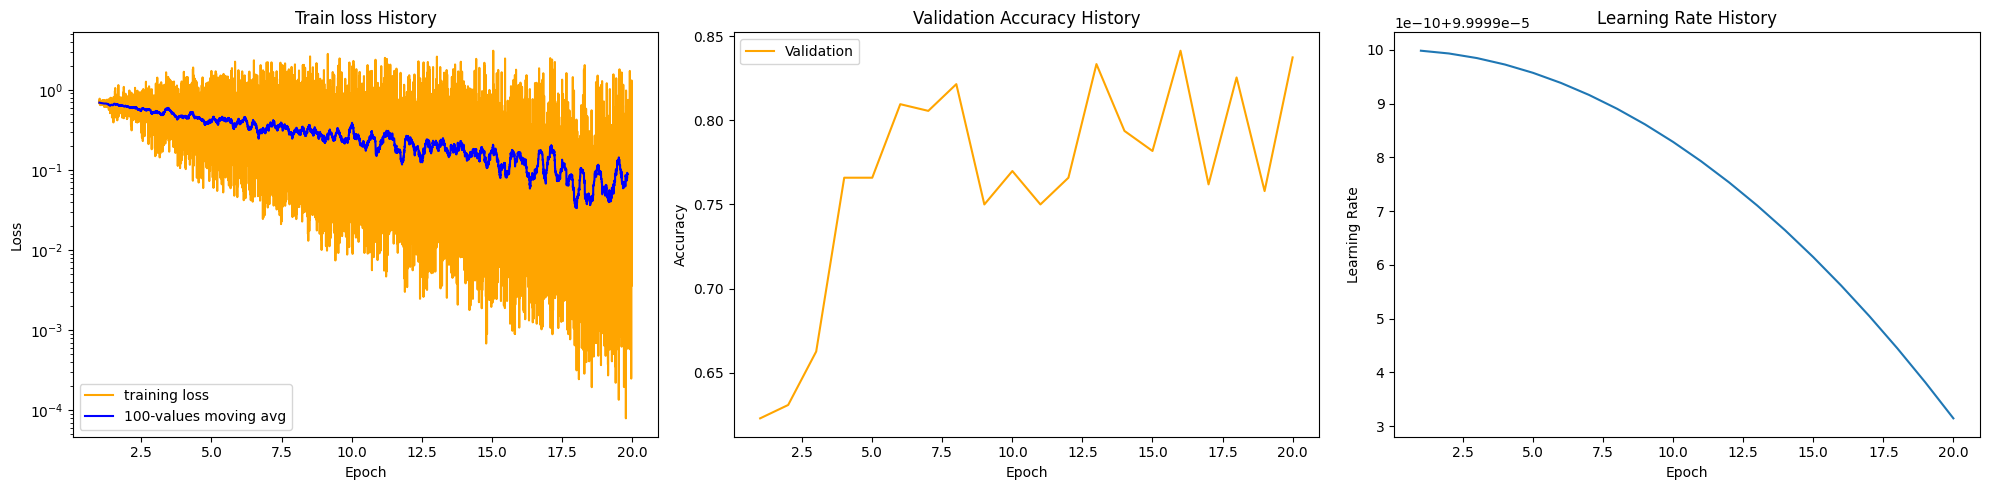

In [29]:
accuracy_history=acc_history_test.copy()
loss_history=loss_history_test
train_loss = loss_history_train.copy()

# Use numpy's convolve function to calculate the moving average
moving_avg_train = np.convolve(train_loss, np.ones(100)/100, mode='valid')
#print(len(train_loss))
#print(len(moving_avg_train))

n_train = len(accuracy_history)

t_test = np.arange(1, num_epochs + 1)
t_train = np.linspace(1,num_epochs,len(loss_history_train))

fig, axs = plt.subplots(1, 3, figsize=(20, 5))

# Plotting training loss history
axs[0].semilogy(t_train, train_loss, color='orange', label="training loss")
axs[0].semilogy((t_train[:-99]), moving_avg_train, color='blue', label="100-values moving avg")
axs[0].legend()
axs[0].set_title('Train loss History')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')

axs[1].plot(t_test, accuracy_history, label="Validation", color='orange')
axs[1].set_title('Validation Accuracy History')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

axs[2].plot(t_test, lr_history_train)
axs[2].set_title('Learning Rate History')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Learning Rate')

plt.tight_layout()
plt.show()


In [30]:
@torch.no_grad()
def compute_f1(model, device, test_loader):
    model.eval()
    batch_f1 = np.zeros(len(test_loader))

    for batch_idx, (data, target) in enumerate(test_loader):    # iterate over each minibatch
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = torch.argmax(output, dim=1).float().clone().detach().requires_grad_(False)

        batch_f1[batch_idx] = multiclass_f1_score(pred, target, num_classes=2)   # compute the F1 score for 1 minibatch

    f1_score = np.sum(batch_f1) / len(test_loader)  # Output is the average of the f1 score over all minibatches

    return f1_score

In [31]:
best_idx = np.argmax(accuracy_history)

print(f"The best validation accuracy was obtained on epoch {t_test[best_idx]} and was {accuracy_history[best_idx]*100:.2f} %. \n ")
print(f"The F1-score of this model is {compute_f1(model, device, test_loader)}. ")


The best validation accuracy was obtained on epoch 16 and was 84.13 %. 
 
The F1-score of this model is 0.8692307692307693. 


## 7. Debugging tools

### a) Confusion matrix

predictions:  [1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

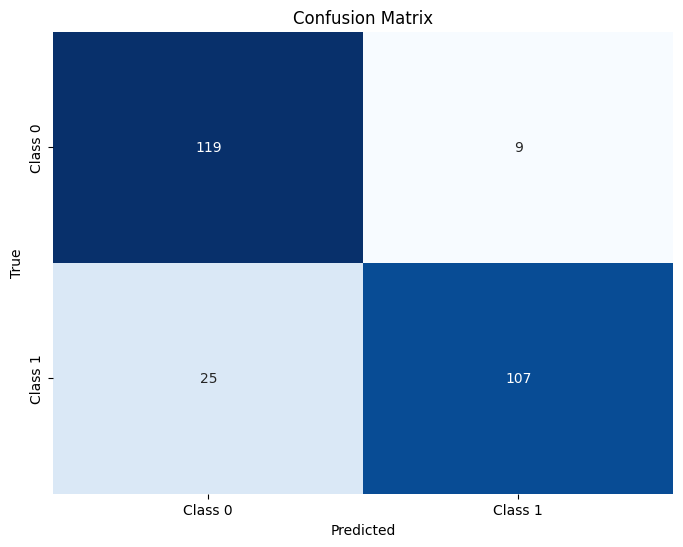

In [32]:
# Convert PyTorch tensors to NumPy arrays
model.eval()
predictions = []
labels = []
model = model.to(device)

for data, target in test_loader:
  data, target = data.to(device), target.to(device)
  output = model(data)
  pred = torch.argmax(output, dim=1).float().clone().detach().requires_grad_(False)
  pred = pred.cpu().numpy()
  target = target.cpu().numpy()
  target = np.array([t.item() for t in target], dtype=float)
  target = np.array(target, dtype=float)
  predictions.extend(pred)
  labels.extend(target)

print("predictions: ", predictions)
print("labels: ", labels)


# Compute confusion matrix using scikit-learn
cm = confusion_matrix(labels, predictions)

# Create a heatmap for visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Class 0", "Class 1"],
            yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

### b) Visualize misclassified images

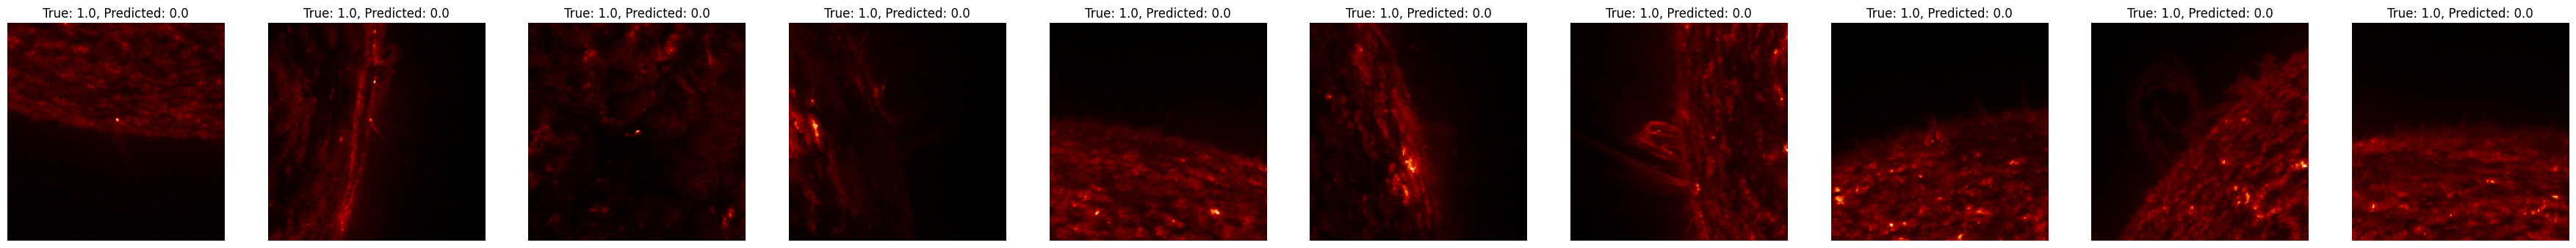

In [33]:
# Set the model to evaluation mode
model.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

misclassified_images = []
true_labels = []
predicted_labels = []

# Iterate through the test set
for data, target in test_loader:
    # Forward pass
    data, target = data.to(device), target.to(device)
    output = model(data)
    pred = torch.argmax(output, dim=1).float().clone().detach().requires_grad_(False)

    # Identify misclassified images
    misclassified_mask = pred != target
    misclassified_images.extend(data[misclassified_mask])
    true_labels.extend(target[misclassified_mask])
    predicted_labels.extend(pred[misclassified_mask])

# Convert lists to PyTorch tensors
misclassified_images = torch.stack(misclassified_images)
true_labels = torch.stack(true_labels)
predicted_labels = torch.stack(predicted_labels)

# Assuming you have a function to reverse normalization if applied during data preprocessing
# Replace reverse_normalize with your actual function
# Example:
reverse_normalize = transforms.Compose([transforms.Normalize(mean=0, std=(1/62.7087)),
                                        transforms.Normalize(mean=-51.6644, std=1)])

# Display misclassified images
num_images_to_display = min(10, len(misclassified_images))
fig, axes = plt.subplots(1, num_images_to_display, figsize=(45,6))

for i in range(num_images_to_display):
    # Assuming images are in RGB format
    image = reverse_normalize(misclassified_images[i]).cpu().numpy()
    true_label = true_labels[i].item()
    predicted_label = predicted_labels[i].item()

    axes[i].imshow(image[15,:,:], cmap='sdoaia304')
    axes[i].set_title(f'True: {true_label}, Predicted: {predicted_label}')
    axes[i].axis('off')

plt.show()


## Save the model

In [34]:
#torch.save(model, 'entire_model.pth') #may be really large, model = torch.load('entire_model.pth')
#torch.save(model.state_dict(), 'model_weights.pth')# model = RCNN() , model.load_state_dict(torch.load('model_weights.pth'))